In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from collections import Counter
from collections import defaultdict


# Analysis

Extract data from all the runs from the JSON files.

In [ ]:
# Used for file name generation and path
def generate_csv_filename():
    experiment_names = ["MeritFocus", "AntiBias", "Initials", "LastName"]
    jobs = ["financial analyst", "HR specialist", "retail", "software engineer"]

    error_count = 0

    for experiment_name in experiment_names:
        print(f"Experiment: {experiment_name}")
        for job_title in jobs:
            print(f"Job Title: {job_title}")
            top_counter = Counter()
            top_og_counter = Counter()
            total_counter = Counter()
            folder_path = f"data/intermediary/resume_ranking/gpt-4.1-nano/{job_title}/{experiment_name}/"
            # Run through each file
            for filename in os.listdir(folder_path):
                if filename.endswith(".json"):
                    with open(os.path.join(folder_path, filename), 'r') as f:
                        data = json.load(f)
                    #Extract the demographic information
                    name_to_demograph = {name: demograph for name, demograph in zip([i.lower() for i in data["context"]["default_order"]], data["context"]["demo_order"])}

                    #Processing and clearning model candidate ranking
                    string_choices = data["choices"][0]["message"]["content"]
                    if ',' in string_choices:
                        model_ranking = string_choices.split(",")[0].strip()
                    elif '/n' in string_choices:
                        model_ranking = string_choices.split("/n")[0].strip()
                    elif '\n' in string_choices:
                        model_ranking = string_choices.split("\n")[0].strip()
                    else:
                        model_ranking = string_choices

                    if "1." in model_ranking:
                        model_ranking = model_ranking.split("1.")[1].strip()
                    if  "- " in model_ranking:
                        model_ranking = model_ranking.split("- ")[1].strip()

                    model_ranking = model_ranking.lower()

                    try:
                        model_top_demograph = name_to_demograph[model_ranking]
                        if model_top_demograph:
                            top_counter[model_top_demograph] += 1
                    except KeyError:
                        error_count += 1
                        #print(f"KeyError: {model_ranking} not found in name_to_demograph mapping.")
                        continue

                    # The original first candidate from the context
                    original_first_candidate = data["context"]["default_order"][0].lower()
                    original_first_demograph = name_to_demograph[original_first_candidate]
                    if original_first_demograph:
                        top_og_counter[original_first_demograph] += 1

                    #Count total appearances of each demographic
                    for demograph in name_to_demograph.values():
                        total_counter[demograph] += 1


            demographs = list(set(total_counter.keys()))
            results = []

            #Calc the best selection rate for each demographic
            best_selection_rate = max((top_counter[d]/total_counter[d]) for d in demographs if total_counter[d] > 0)

            #Calc selection rate and disparate impact ratio for each demographic
            for demograph in demographs:
                total = total_counter[demograph]
                top = top_counter[demograph]
                top_og = top_og_counter[demograph]
                selection_rate = top / total if total > 0 else 0
                disparate_impact_ratio = selection_rate / best_selection_rate if best_selection_rate > 0 else 0
                
                results.append({
                    "demograph": demograph,
                    "top": top,
                    "top_og": top_og,
                    "selection_rate": round(selection_rate, 4),
                    "disparate_impact_ratio": round(disparate_impact_ratio, 4)
                })

            df_final = pd.DataFrame(results)
            print(df_final)
            df_final.to_csv(f"data/output/{job_title}_{experiment_name}.csv", index=False)
            #print("error",error_count)

            
generate_csv_filename()

In [168]:
directory_path = "data/output/"

experiments_results = {}
# Loop over all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Store it in the dictionary, using the filename (without .csv) as the key
        key = os.path.splitext(filename)[0]
        experiments_results[key] = df


In [169]:
directory = 'data/output'

max_top_og_values = {}

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        try:
            df = pd.read_csv(filepath)
            if 'top_og' in df.columns:
                max_top_og = df['top_og'].max()
                max_top_og_values[filename] = max_top_og
            else:
                max_top_og_values[filename] = None
        except Exception as e:
            max_top_og_values[filename] = f"Error reading file: {e}"

# Convert results to a DataFrame for better viewing
result_df = pd.DataFrame(list(max_top_og_values.items()), columns=['CSV File', 'Max top_og'])

print(result_df)


                            CSV File  Max top_og
0     financial analyst_AntiBias.csv         131
1     financial analyst_Initials.csv         135
2     financial analyst_LastName.csv         136
3   financial analyst_MeritFocus.csv         131
4         HR specialist_AntiBias.csv         132
5         HR specialist_Initials.csv         137
6         HR specialist_LastName.csv         138
7       HR specialist_MeritFocus.csv         132
8                retail_AntiBias.csv         132
9                retail_Initials.csv         137
10               retail_LastName.csv         138
11             retail_MeritFocus.csv         133
12    software engineer_AntiBias.csv         131
13    software engineer_Initials.csv         138
14    software engineer_LastName.csv         138
15  software engineer_MeritFocus.csv         133


A disparate impact ratio < 0.8 often suggests potential discrimination under U.S. EEOC guidelines.

In [170]:
experiments_results

{'financial analyst_AntiBias':   demograph  top  top_og  selection_rate  disparate_impact_ratio
 0       W_W  132     119          0.1410                  1.0000
 1       B_M  100     114          0.1068                  0.7576
 2       H_W  125     131          0.1335                  0.9470
 3       W_M  118     121          0.1261                  0.8939
 4       A_M  121     107          0.1293                  0.9167
 5       H_M  114     105          0.1218                  0.8636
 6       B_W  113     130          0.1207                  0.8561
 7       A_W  113     109          0.1207                  0.8561,
 'financial analyst_Initials':   demograph  top  top_og  selection_rate  disparate_impact_ratio
 0       W_W  125     124          0.1297                  0.9241
 1       B_M  117     119          0.1215                  0.8659
 2       H_W  132     130          0.1364                  0.9718
 3       W_M  127     130          0.1312                  0.9350
 4       A_M  1

### ONLY RUN ONCE!!!

In [186]:
# ONLY RUN ONCE!!!
threshold = 150
import shutil

# Helper to load samples
def load_samples(demograph, needed_samples, sample_dir):
    samples = 0
    sample_idx = 0
    parent_dir = os.path.abspath(os.path.join(sample_dir, os.pardir))

    while samples < needed_samples:
        sample_file = os.path.join(sample_dir, demograph+"_sample_{sample_idx}.json".format(sample_idx = sample_idx))
        print("sample_file",sample_file)
        if os.path.exists(sample_file):
            # Move the file up
            destination_path = os.path.join(parent_dir, os.path.basename(sample_file))
            print(destination_path)
            shutil.move(sample_file, destination_path)
            print(f"Moved {os.path.basename(sample_file)} to {parent_dir}.")
            samples += 1
        else:
            print(f"No more sample files for {demograph}.")
            break
        sample_idx += 1


# Now process the experiments_results
for experiment_name, df in experiments_results.items():
    for idx, row in df.iterrows():
        demograph = row['demograph']
        top_og = row['top_og']
        if top_og < threshold:
            job_name = experiment_name.split('_')[0] # used for rebalance path
            exp_name = experiment_name.split('_')[1]
            needed_samples = threshold - top_og
            print(f"{demograph} needs {needed_samples} more samples in {experiment_name}.")
            sample_dir = f'data/intermediary/resume_ranking/gpt-4.1-nano/{job_name}/{exp_name}/rebalance'
            print(sample_dir)
            load_samples(demograph, needed_samples, sample_dir)
                

W_W needs 31 more samples in financial analyst_AntiBias.
data/intermediary/resume_ranking/gpt-4.1-nano/financial analyst/AntiBias/rebalance
sample_file data/intermediary/resume_ranking/gpt-4.1-nano/financial analyst/AntiBias/rebalance\W_W_sample_0.json
No more sample files for W_W.
B_M needs 36 more samples in financial analyst_AntiBias.
data/intermediary/resume_ranking/gpt-4.1-nano/financial analyst/AntiBias/rebalance
sample_file data/intermediary/resume_ranking/gpt-4.1-nano/financial analyst/AntiBias/rebalance\B_M_sample_0.json
c:\Users\Jespe\Desktop\BackUp_Restart\School_stuff\Masters\Algorithmic Fairness\Exam\data\intermediary\resume_ranking\gpt-4.1-nano\financial analyst\AntiBias\B_M_sample_0.json
Moved B_M_sample_0.json to c:\Users\Jespe\Desktop\BackUp_Restart\School_stuff\Masters\Algorithmic Fairness\Exam\data\intermediary\resume_ranking\gpt-4.1-nano\financial analyst\AntiBias.
sample_file data/intermediary/resume_ranking/gpt-4.1-nano/financial analyst/AntiBias/rebalance\B_M_sam

In [188]:
generate_csv_filename()

Experiment: MeritFocus
Job Title: financial analyst
  demograph  top  top_og  selection_rate  disparate_impact_ratio
0       W_W  159     147          0.1349                  1.0000
1       B_M  142     149          0.1204                  0.8931
2       H_W  150     150          0.1272                  0.9434
3       W_M  145     148          0.1230                  0.9119
4       A_M  143     146          0.1213                  0.8994
5       H_M  149     146          0.1264                  0.9371
6       B_W  146     146          0.1238                  0.9182
7       A_W  145     147          0.1230                  0.9119
Job Title: HR specialist
  demograph  top  top_og  selection_rate  disparate_impact_ratio
0       W_W  150     136          0.1395                  0.9202
1       H_W  163     149          0.1516                  1.0000
2       B_M  132     115          0.1228                  0.8098
3       W_M  120     131          0.1116                  0.7362
4       A_M  

# Overall selection rates by groups

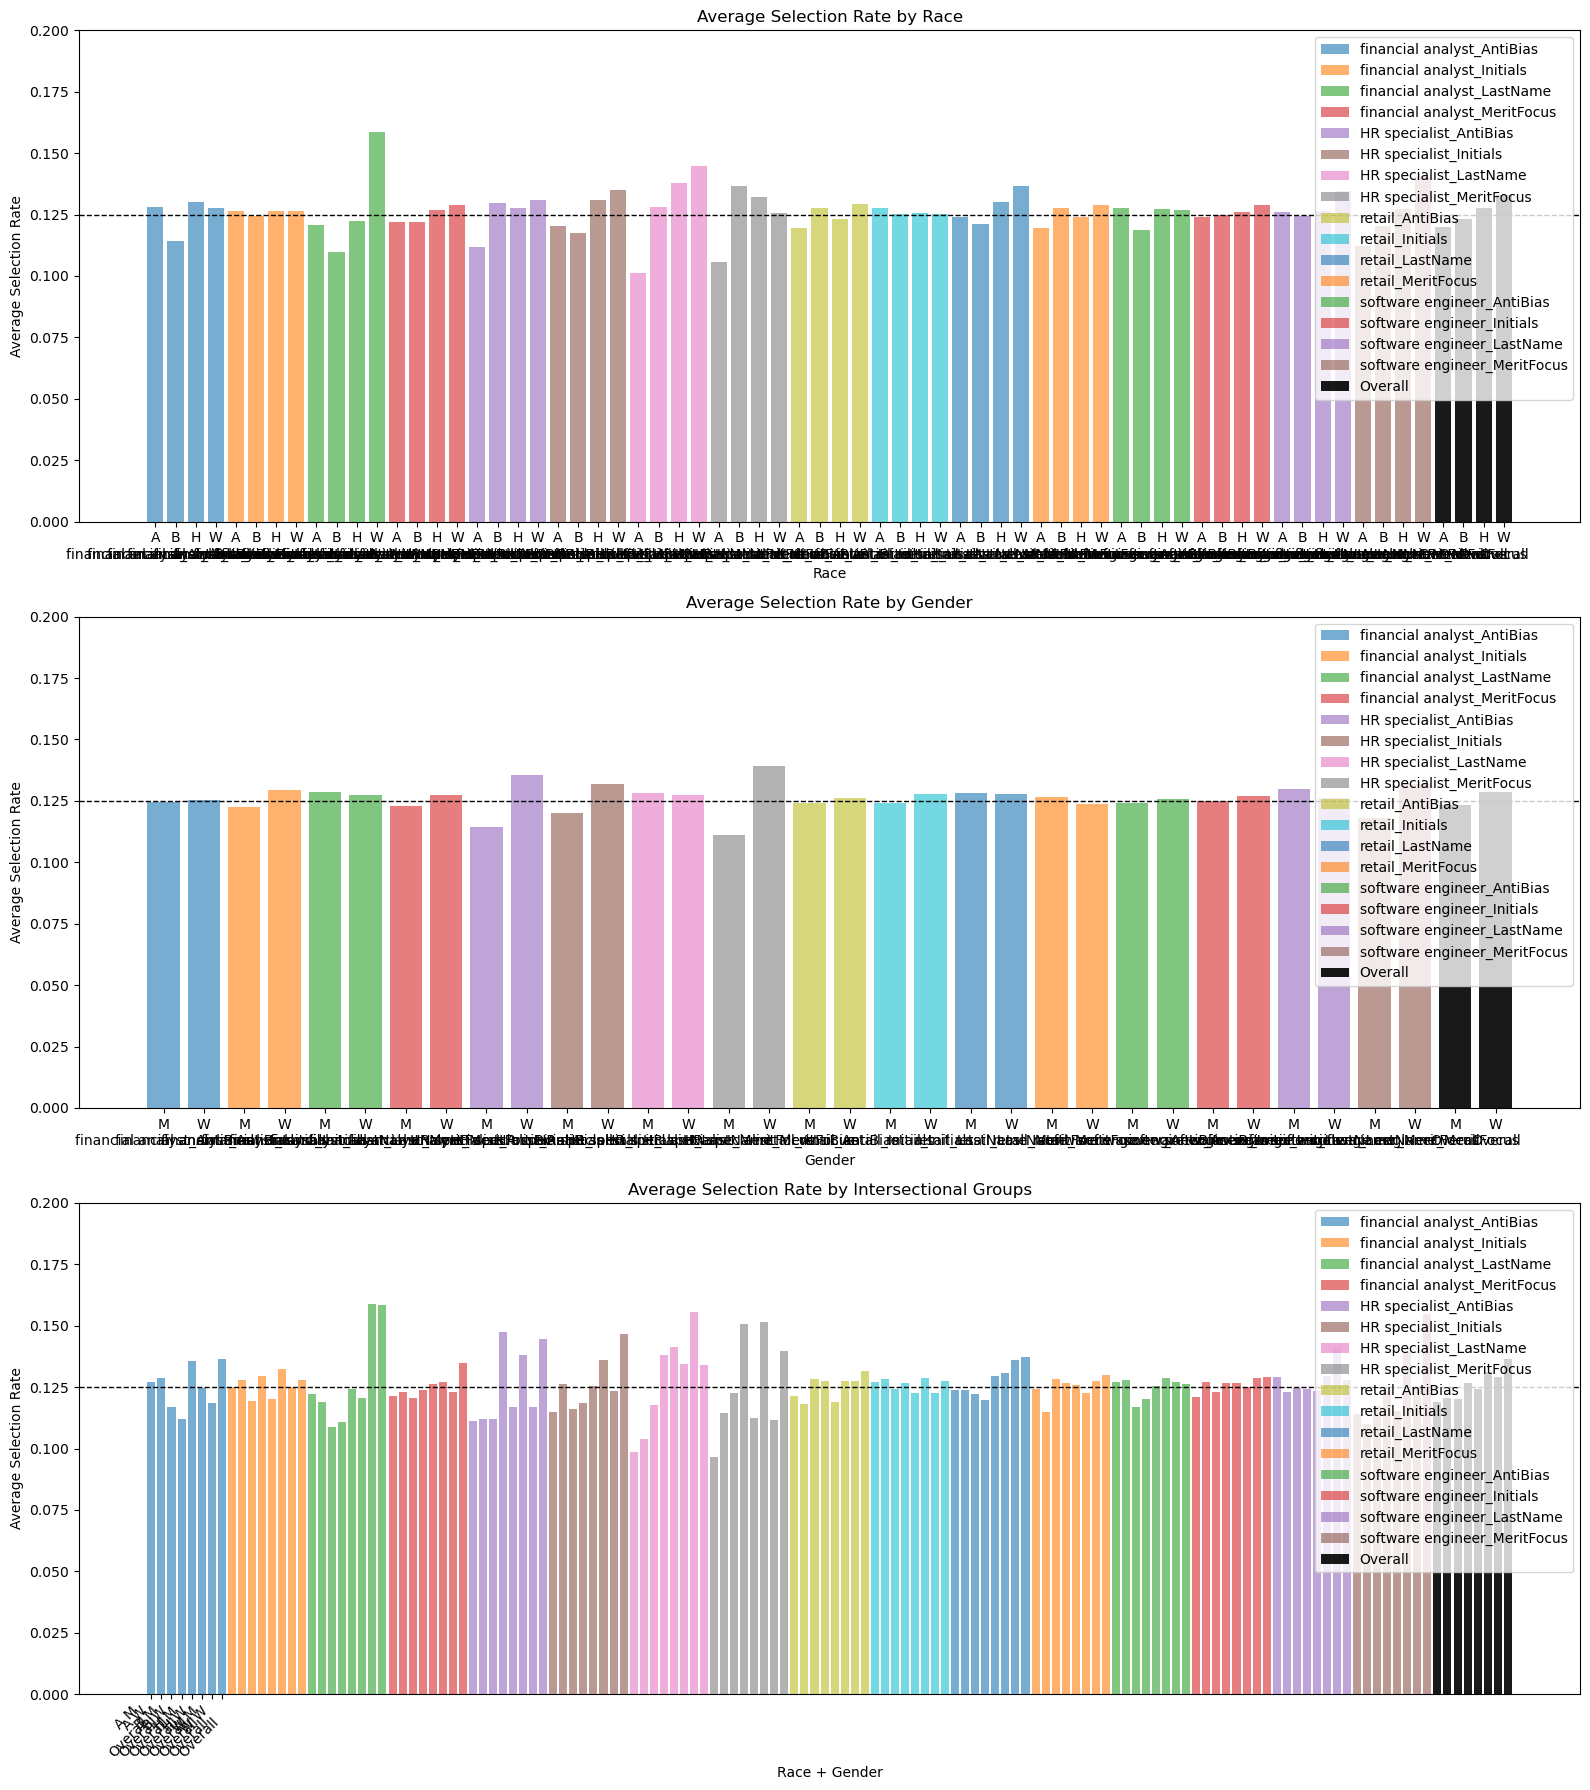

In [243]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load Data ---
directory_path = "data/output/"

experiments_results = {}
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        key = os.path.splitext(filename)[0]
        experiments_results[key] = df




def plot_all_selection_rates_together(dataframes):
    # Combine all experiments
    all_data = pd.concat(dataframes.values(), keys=dataframes.keys(), names=['experiment', 'row']).reset_index(level='experiment')

    # Split 'demograph' into 'race' and 'gender'
    all_data[['race', 'gender']] = all_data['demograph'].str.split('_', expand=True)
    colors = plt.cm.tab10.colors  # Up to 10 distinct colors
    fig, axes = plt.subplots(3, 1, figsize=(16, 18))  # 3 rows, 1 column

    ### Race subplot ###
    ax = axes[0]
    for idx, (name, df) in enumerate(dataframes.items()):
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)
        race_group = df.groupby('race')['selection_rate'].mean().reset_index()
        ax.bar(race_group['race'] + f'\n{name}', race_group['selection_rate'],
               color=colors[idx % len(colors)], alpha=0.6, label=name)

    race_group_overall = all_data.groupby('race')['selection_rate'].mean().reset_index()
    ax.bar(race_group_overall['race'] + '\nOverall', race_group_overall['selection_rate'],
           color='black', alpha=0.9, label='Overall')

    ax.set_xlabel('Race')
    ax.set_ylabel('Average Selection Rate')
    ax.set_title('Average Selection Rate by Race')
    ax.set_ylim(0, 0.2)

    # Dashed fairness line
    ax.axhline(y=0.125, color='black', linestyle='--', linewidth=1)
    ax.legend()

    ### Gender subplot ###
    ax = axes[1]

    for idx, (name, df) in enumerate(dataframes.items()):
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)
        gender_group = df.groupby('gender')['selection_rate'].mean().reset_index()
        ax.bar(gender_group['gender'] + f'\n{name}', gender_group['selection_rate'],
               color=colors[idx % len(colors)], alpha=0.6, label=name)

    gender_group_overall = all_data.groupby('gender')['selection_rate'].mean().reset_index()
    ax.bar(gender_group_overall['gender'] + '\nOverall', gender_group_overall['selection_rate'],
           color='black', alpha=0.9, label='Overall')

    ax.set_xlabel('Gender')
    ax.set_ylabel('Average Selection Rate')
    ax.set_title('Average Selection Rate by Gender')
    ax.set_ylim(0, 0.2)

    # Dashed fairness line
    ax.axhline(y=0.125, color='black', linestyle='--', linewidth=1)
    ax.legend()

    ### Intersectional subplot ###
    ax = axes[2]

    for idx, (name, df) in enumerate(dataframes.items()):
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)
        intersection_group = df.groupby(['race', 'gender'])['selection_rate'].mean().reset_index()
        intersection_labels = intersection_group['race'] + ' ' + intersection_group['gender'] + f'\n{name}'
        ax.bar(intersection_labels, intersection_group['selection_rate'],
               color=colors[idx % len(colors)], alpha=0.6, label=name)

    intersection_group_overall = all_data.groupby(['race', 'gender'])['selection_rate'].mean().reset_index()
    intersection_labels_overall = intersection_group_overall['race'] + ' ' + intersection_group_overall['gender'] + '\nOverall'
    ax.bar(intersection_labels_overall, intersection_group_overall['selection_rate'],
           color='black', alpha=0.9, label='Overall')

    ax.set_xlabel('Race + Gender')
    ax.set_ylabel('Average Selection Rate')
    ax.set_title('Average Selection Rate by Intersectional Groups')
    ax.set_xticks(range(len(intersection_labels_overall)))
    ax.set_xticklabels(intersection_labels_overall, rotation=45, ha='right')
    ax.set_ylim(0, 0.2)

    # Dashed fairness line
    ax.axhline(y=0.125, color='black', linestyle='--', linewidth=1)
    ax.legend()

    plt.tight_layout()
    plt.savefig("plots/all_data.png", bbox_inches='tight')
    plt.show()



plot_all_selection_rates_together(experiments_results)


In [195]:
experiments_results["retail_LastName"]

demograph  top  top_og  selection_rate  disparate_impact_ratio
0       W_W  160     151          0.1372                  1.0000
1       H_W  153     151          0.1308                  0.9530
2       B_M  142     146          0.1224                  0.8921
3       W_M  158     148          0.1362                  0.9926
4       A_M  144     147          0.1238                  0.9023
5       H_M  151     148          0.1297                  0.9454
6       B_W  139     151          0.1196                  0.8717
7       A_W  146     151          0.1239                  0.9032

### Effect of experiment to each job

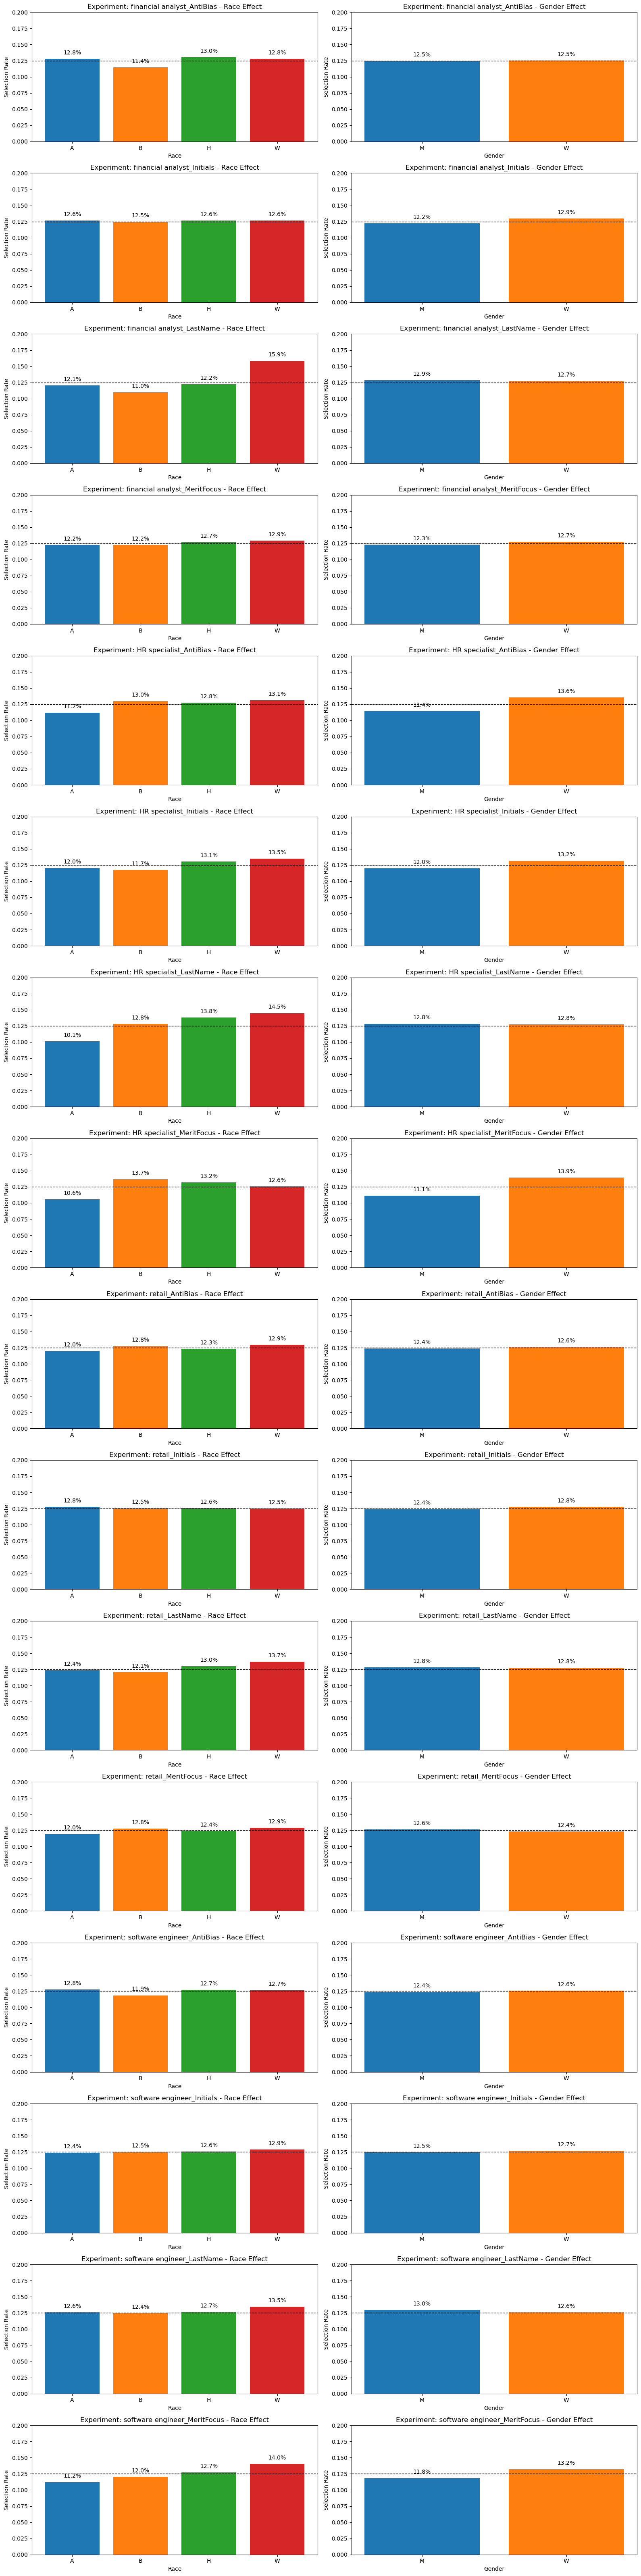

In [ ]:
directory_path = "data/output/"

experiments_results = {}
for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        key = os.path.splitext(filename)[0]
        experiments_results[key] = df



def plot_experiment_effects(dataframes):
    num_experiments = len(dataframes)
    colors = plt.cm.tab10.colors  # colors for races and genders

    fig, axes = plt.subplots(num_experiments, 2, figsize=(16, 4 * num_experiments))  # 2 columns (Race and Gender)

    if num_experiments == 1:
        axes = np.array([axes])  # make it consistent when only 1 experiment

    for idx, (name, df) in enumerate(dataframes.items()):
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)

        ### Race plot ###
        race_group = df.groupby('race')['selection_rate'].mean().reset_index()

        ax_race = axes[idx, 0]
        bars = ax_race.bar(race_group['race'], race_group['selection_rate'], color=colors[:len(race_group)])
        ax_race.set_ylim(0, 0.2)
        ax_race.set_title(f'Experiment: {name} - Race Effect')
        ax_race.set_xlabel('Race')
        ax_race.set_ylabel('Selection Rate')

        # Dashed fairness line at 12.5%
        ax_race.axhline(y=0.125, color='black', linestyle='--', linewidth=1)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax_race.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.1%}', ha='center', va='bottom')

        ### Gender plot ###
        gender_group = df.groupby('gender')['selection_rate'].mean().reset_index()

        ax_gender = axes[idx, 1]
        bars = ax_gender.bar(gender_group['gender'], gender_group['selection_rate'], color=colors[:len(gender_group)])
        ax_gender.set_ylim(0, 0.2)
        ax_gender.set_title(f'Experiment: {name} - Gender Effect')
        ax_gender.set_xlabel('Gender')
        ax_gender.set_ylabel('Selection Rate')

        # --- Add dashed fairness line at 12.5% ---
        ax_gender.axhline(y=0.125, color='black', linestyle='--', linewidth=1)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax_gender.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.1%}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()



plot_experiment_effects(experiments_results)


In [251]:
import math
import matplotlib.pyplot as plt
import os

def plot_gender_only_grid(dataframes, cols=2, save_path="plots/gender_only_grid.png"):
    num_experiments = len(dataframes)
    rows = math.ceil(num_experiments / cols)
    colors = plt.cm.tab10.colors

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
    axes = axes.flatten() if num_experiments > 1 else [axes]

    for idx, (name, df) in enumerate(dataframes.items()):
        ax = axes[idx]
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)
        gender_group = df.groupby('gender')['selection_rate'].mean().reset_index()

        bars = ax.bar(gender_group['gender'], gender_group['selection_rate'], color=colors[:len(gender_group)])
        ax.set_ylim(0, 0.2)
        ax.set_title(f'{name} - Gender Effect')
        ax.set_xlabel('Gender')
        ax.set_ylabel('Selection Rate')
        ax.axhline(y=0.125, color='black', linestyle='--', linewidth=1)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.1%}', ha='center', va='bottom')

    # Remove any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()
    print(f"Saved gender grid to {save_path}")


### Jobs averaged over all experiments.

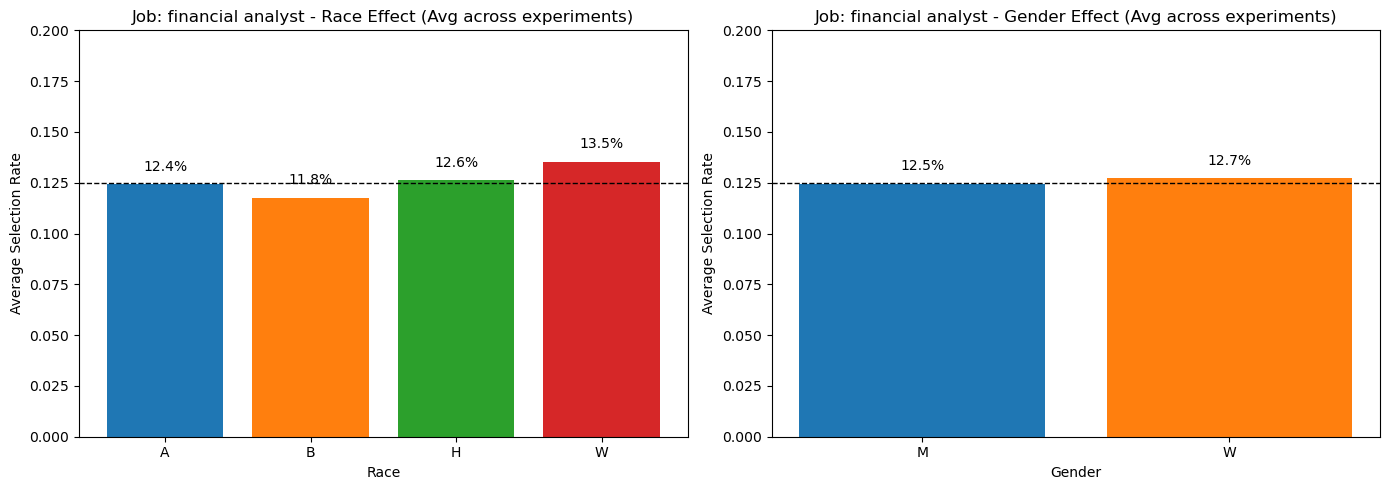

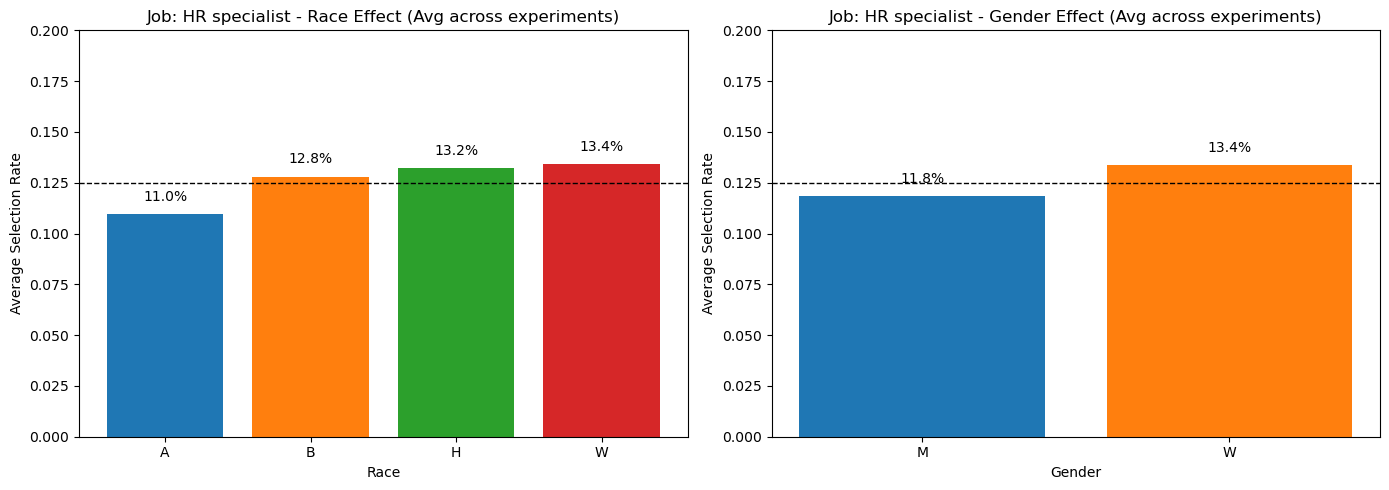

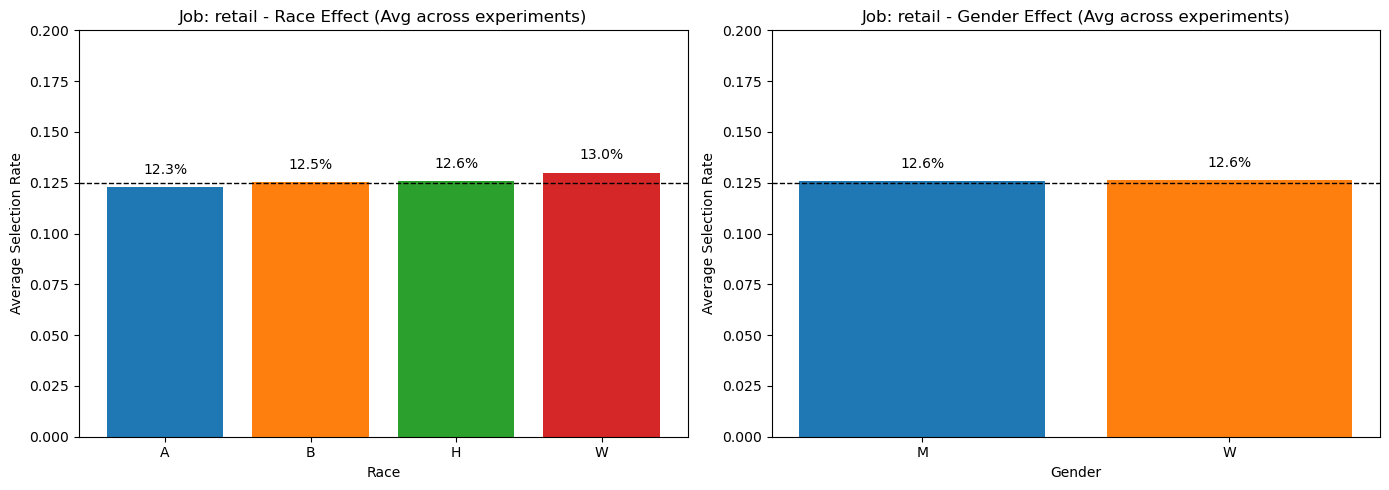

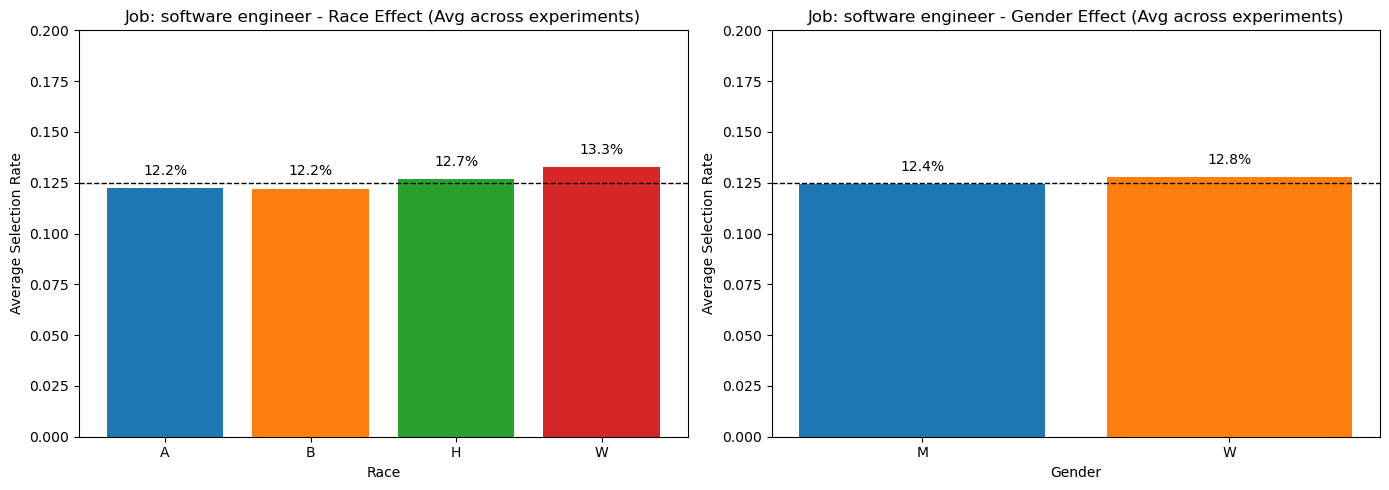

In [ ]:
jobs_data = defaultdict(list)

for name, df in experiments_results.items():
    job_title = name.split('_')[0]  # take the part before the first underscore
    df = df.copy()
    # Split demograph into race and gender
    df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)
    jobs_data[job_title].append(df)

def plot_job_averages(jobs_data):
    colors = plt.cm.tab10.colors

    for job_title, dfs in jobs_data.items():
        # Merge all experiment results for this job
        df_all = pd.concat(dfs, ignore_index=True)

        # Race agg
        race_group = df_all.groupby('race')['selection_rate'].mean().reset_index()

        # Gender agg
        gender_group = df_all.groupby('gender')['selection_rate'].mean().reset_index()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        ### Race plot ###
        ax_race = axes[0]
        bars = ax_race.bar(race_group['race'], race_group['selection_rate'], color=colors[:len(race_group)])
        ax_race.set_ylim(0, max(0.2, race_group['selection_rate'].max() * 1.2))
        ax_race.set_title(f'Job: {job_title} - Race Effect (Avg across experiments)')
        ax_race.set_xlabel('Race')
        ax_race.set_ylabel('Average Selection Rate')
        
        # Dashed fairness line at 12.5%
        ax_race.axhline(y=0.125, color='black', linestyle='--', linewidth=1)

        for bar in bars:
            height = bar.get_height()
            ax_race.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.1%}', ha='center', va='bottom')

        ### Gender plot ###
        ax_gender = axes[1]
        bars = ax_gender.bar(gender_group['gender'], gender_group['selection_rate'], color=colors[:len(gender_group)])
        ax_gender.set_ylim(0, max(0.2, gender_group['selection_rate'].max() * 1.2))
        ax_gender.set_title(f'Job: {job_title} - Gender Effect (Avg across experiments)')
        ax_gender.set_xlabel('Gender')
        ax_gender.set_ylabel('Average Selection Rate')
        
        # --- Add dashed fairness line at 12.5% ---
        ax_gender.axhline(y=0.125, color='black', linestyle='--', linewidth=1)

        for bar in bars:
            height = bar.get_height()
            ax_gender.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.1%}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()



plot_job_averages(jobs_data)


### Breakdown of each experiments effect on each job

In [224]:
import os

def plot_job_experiment_breakdown(jobs_data, save_dir=None):
    colors = plt.cm.tab10.colors

    for job_title, experiments in jobs_data.items():
        num_experiments = len(experiments)

        fig_race, axes_race = plt.subplots(1, num_experiments, figsize=(5 * num_experiments, 5))
        fig_gender, axes_gender = plt.subplots(1, num_experiments, figsize=(5 * num_experiments, 5))

        # If only one experiment, axes might not be an array
        if num_experiments == 1:
            axes_race = [axes_race]
            axes_gender = [axes_gender]

        for idx, (experiment_name, df) in enumerate(experiments.items()):
            # Race aggregation
            race_group = df.groupby('race')['selection_rate'].mean().reset_index()

            ax_race = axes_race[idx]
            bars = ax_race.bar(race_group['race'], race_group['selection_rate'], color=colors[:len(race_group)])
            ax_race.set_ylim(0, max(0.2, race_group['selection_rate'].max() * 1.2))
            ax_race.set_title(f'{job_title} - {experiment_name} (Race)')
            ax_race.set_xlabel('Race')
            ax_race.set_ylabel('Selection Rate')
            ax_race.axhline(y=0.125, color='black', linestyle='--', linewidth=1)

            for bar in bars:
                height = bar.get_height()
                ax_race.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.1%}', ha='center', va='bottom')

            # Gender aggregation
            gender_group = df.groupby('gender')['selection_rate'].mean().reset_index()

            ax_gender = axes_gender[idx]
            bars = ax_gender.bar(gender_group['gender'], gender_group['selection_rate'], color=colors[:len(gender_group)])
            ax_gender.set_ylim(0, max(0.2, gender_group['selection_rate'].max() * 1.2))
            ax_gender.set_title(f'{job_title} - {experiment_name} (Gender)')
            ax_gender.set_xlabel('Gender')
            ax_gender.set_ylabel('Selection Rate')
            ax_gender.axhline(y=0.125, color='black', linestyle='--', linewidth=1)

            for bar in bars:
                height = bar.get_height()
                ax_gender.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.1%}', ha='center', va='bottom')

        fig_race.suptitle(f'Job: {job_title} - Race Breakdown by Experiment', fontsize=16)
        fig_gender.suptitle(f'Job: {job_title} - Gender Breakdown by Experiment', fontsize=16)

        plt.tight_layout()

        # Saving logic
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            job_clean = job_title.replace(" ", "_")
            race_path = os.path.join(save_dir, f"{job_clean}_race_breakdown.png")
            gender_path = os.path.join(save_dir, f"{job_clean}_gender_breakdown.png")
            fig_race.savefig(race_path, bbox_inches='tight')
            fig_gender.savefig(gender_path, bbox_inches='tight')
            plt.close(fig_race)
            plt.close(fig_gender)
        else:
            plt.show()


# Example usage
save_directory = "plots/job_experiment_breakdown"
plot_job_experiment_breakdown(jobs_data, save_dir=save_directory)


## Statistical Parity Difference

### Race

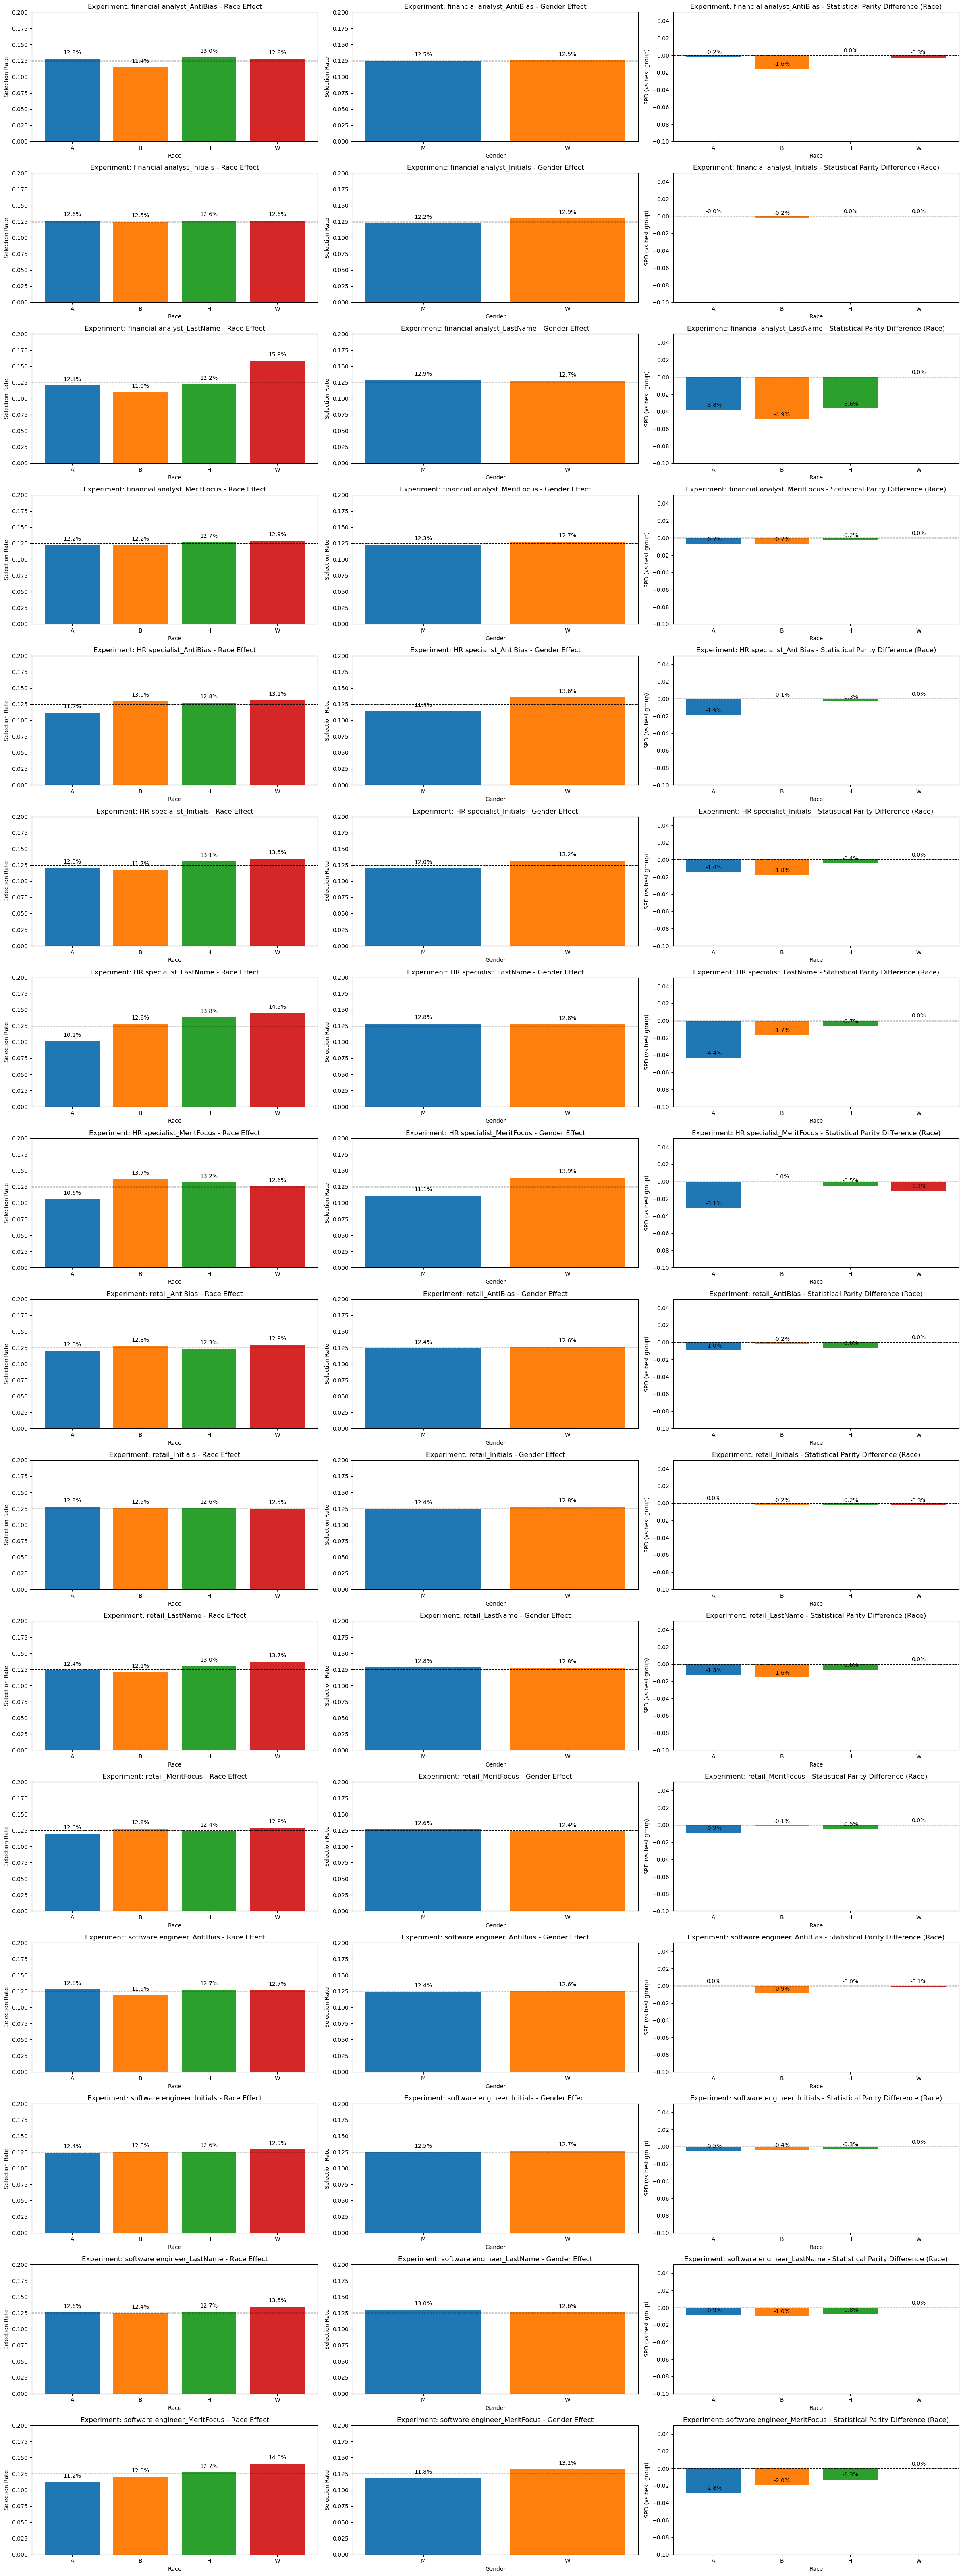

In [222]:
def plot_experiment_effects_with_spd(dataframes):
    num_experiments = len(dataframes)
    colors = plt.cm.tab10.colors

    fig, axes = plt.subplots(num_experiments, 3, figsize=(24, 4 * num_experiments))  # 3 columns now: Race, Gender, SPD

    if num_experiments == 1:
        axes = np.array([axes])  # ensure consistency for 1 experiment

    for idx, (name, df) in enumerate(dataframes.items()):
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)

        ### Race plot ###
        race_group = df.groupby('race')['selection_rate'].mean().reset_index()
        ax_race = axes[idx, 0]
        bars = ax_race.bar(race_group['race'], race_group['selection_rate'], color=colors[:len(race_group)])
        ax_race.set_ylim(0, 0.2)
        ax_race.set_title(f'Experiment: {name} - Race Effect')
        ax_race.set_xlabel('Race')
        ax_race.set_ylabel('Selection Rate')
        ax_race.axhline(y=0.125, color='black', linestyle='--', linewidth=1)

        for bar in bars:
            height = bar.get_height()
            ax_race.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.1%}', ha='center', va='bottom')

        ### Gender plot ###
        gender_group = df.groupby('gender')['selection_rate'].mean().reset_index()
        ax_gender = axes[idx, 1]
        bars = ax_gender.bar(gender_group['gender'], gender_group['selection_rate'], color=colors[:len(gender_group)])
        ax_gender.set_ylim(0, 0.2)
        ax_gender.set_title(f'Experiment: {name} - Gender Effect')
        ax_gender.set_xlabel('Gender')
        ax_gender.set_ylabel('Selection Rate')
        ax_gender.axhline(y=0.125, color='black', linestyle='--', linewidth=1)

        for bar in bars:
            height = bar.get_height()
            ax_gender.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.1%}', ha='center', va='bottom')

        ### SPD Plot (Race) ###
        # Choose the group with the highest selection rate as reference
        ref_rate = race_group['selection_rate'].max()
        race_group['SPD'] = race_group['selection_rate'] - ref_rate

        ax_spd = axes[idx, 2]
        bars = ax_spd.bar(race_group['race'], race_group['SPD'], color=colors[:len(race_group)])
        ax_spd.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
        ax_spd.set_title(f'Experiment: {name} - Statistical Parity Difference (Race)')
        ax_spd.set_xlabel('Race')
        ax_spd.set_ylabel('SPD (vs best group)')
        ax_spd.set_ylim(-0.1, 0.05)  # adjust based on your data scale

        for bar in bars:
            height = bar.get_height()
            ax_spd.text(bar.get_x() + bar.get_width()/2., height + 0.002, f'{height:.1%}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()




plot_experiment_effects_with_spd(experiments_results)


### Only statisical parity

In [238]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def get_race_spd_heatmap_fixed_white(dataframes, save_path=None):
    spd_results = {}

    for name, df in dataframes.items():
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)

        # Calculate selection rates by race
        race_group = df.groupby('race')['selection_rate'].mean().reset_index()

        # Use "White" as fixed reference group (race == "W")
        if 'W' not in race_group['race'].values:
            print(f"Warning: No 'W' group found in {name}")
            continue

        white_rate = race_group.loc[race_group['race'] == 'W', 'selection_rate'].values[0]

        # Compute SPD relative to White
        race_group['SPD'] = race_group['selection_rate'] - white_rate
        spd_results[name] = race_group.set_index('race')['SPD']

    # Combine into single DataFrame
    spd_df = pd.DataFrame(spd_results).sort_index()

    # --- Plot heatmap ---
    plt.figure(figsize=(12, 6))
    sns.heatmap(spd_df, annot=True, fmt=".3f", cmap="coolwarm", center=0,
                linewidths=0.5, cbar_kws={'label': 'SPD (vs White)'})
    plt.title("Statistical Parity Difference by Race (White as Reference)")
    plt.xlabel("Experiment")
    plt.ylabel("Race")

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved heatmap to {save_path}")
        plt.close()
    else:
        plt.tight_layout()
        plt.show()

    return spd_df



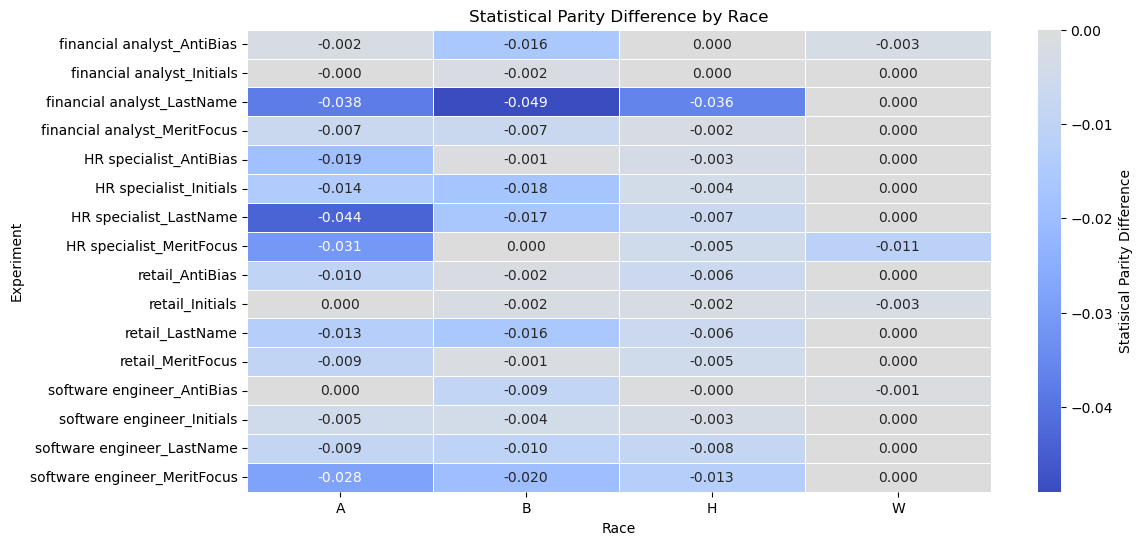

In [ ]:
# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(spd_df.T, annot=True, fmt=".3f", cmap="coolwarm", center=0,
            linewidths=0.5, cbar_kws={'label': 'Statisical Parity Difference'})
plt.title("Statistical Parity Difference by Race")
plt.xlabel("Race")
plt.ylabel("Experiment")

plt.savefig("plots/spd_race_heatmap.png", bbox_inches='tight')


## Gender

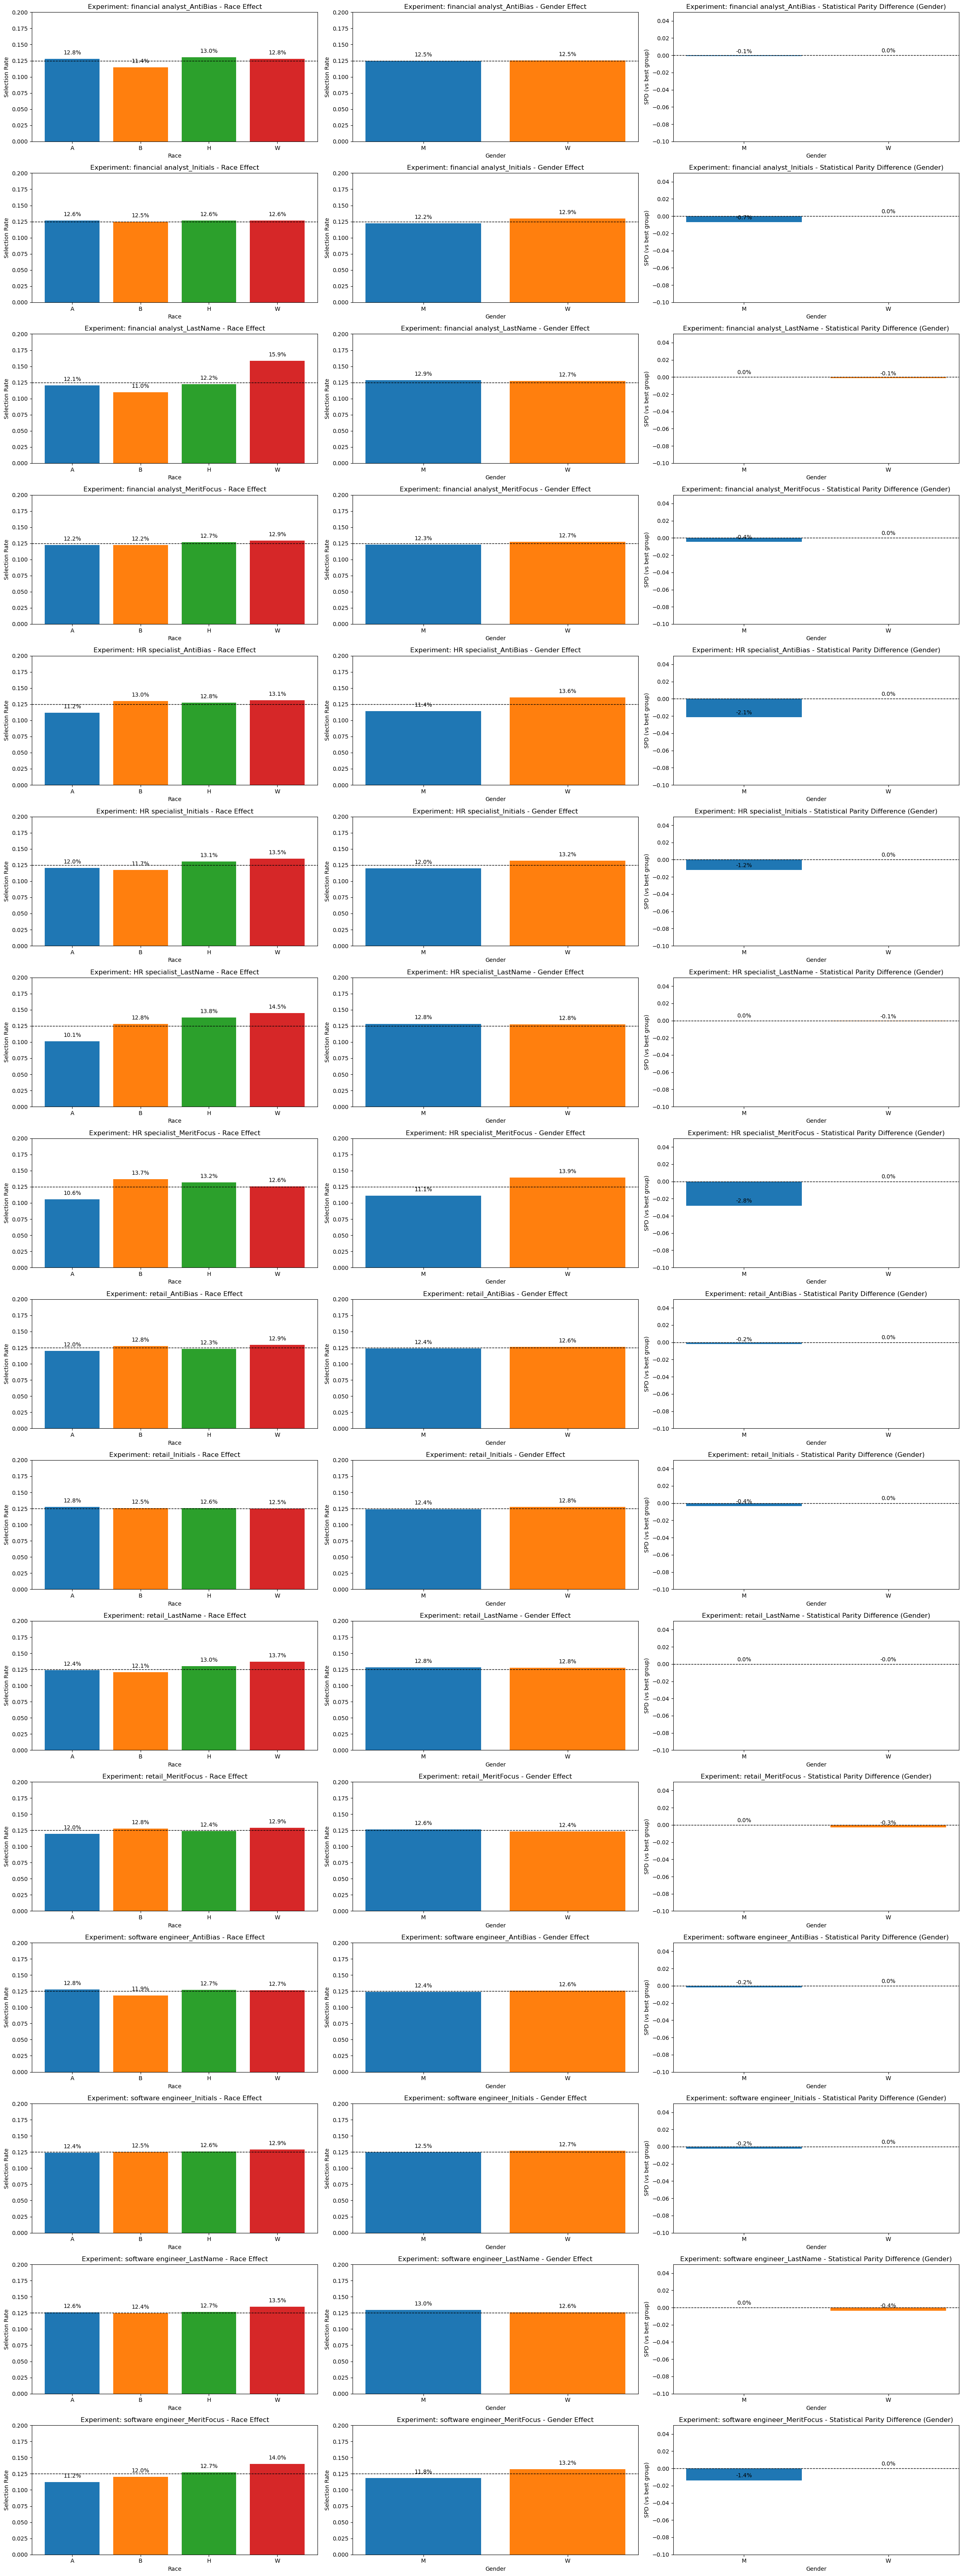

In [217]:
def plot_experiment_effects_with_spd_gender(dataframes):
    num_experiments = len(dataframes)
    colors = plt.cm.tab10.colors

    fig, axes = plt.subplots(num_experiments, 3, figsize=(24, 4 * num_experiments))  # 3 columns (Race, Gender, SPD-Gender)

    if num_experiments == 1:
        axes = np.array([axes])  # ensure consistent structure

    for idx, (name, df) in enumerate(dataframes.items()):
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)

        ### Race Plot ###
        race_group = df.groupby('race')['selection_rate'].mean().reset_index()
        ax_race = axes[idx, 0]
        bars = ax_race.bar(race_group['race'], race_group['selection_rate'], color=colors[:len(race_group)])
        ax_race.set_ylim(0, 0.2)
        ax_race.set_title(f'Experiment: {name} - Race Effect')
        ax_race.set_xlabel('Race')
        ax_race.set_ylabel('Selection Rate')
        ax_race.axhline(y=0.125, color='black', linestyle='--', linewidth=1)

        for bar in bars:
            height = bar.get_height()
            ax_race.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.1%}', ha='center', va='bottom')

        ### Gender Plot ###
        gender_group = df.groupby('gender')['selection_rate'].mean().reset_index()
        ax_gender = axes[idx, 1]
        bars = ax_gender.bar(gender_group['gender'], gender_group['selection_rate'], color=colors[:len(gender_group)])
        ax_gender.set_ylim(0, 0.2)
        ax_gender.set_title(f'Experiment: {name} - Gender Effect')
        ax_gender.set_xlabel('Gender')
        ax_gender.set_ylabel('Selection Rate')
        ax_gender.axhline(y=0.125, color='black', linestyle='--', linewidth=1)

        for bar in bars:
            height = bar.get_height()
            ax_gender.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.1%}', ha='center', va='bottom')

        ### SPD Plot for Gender ###
        ref_rate = gender_group['selection_rate'].max()
        gender_group['SPD'] = gender_group['selection_rate'] - ref_rate

        ax_spd = axes[idx, 2]
        bars = ax_spd.bar(gender_group['gender'], gender_group['SPD'], color=colors[:len(gender_group)])
        ax_spd.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
        ax_spd.set_title(f'Experiment: {name} - Statistical Parity Difference (Gender)')
        ax_spd.set_xlabel('Gender')
        ax_spd.set_ylabel('SPD (vs best group)')
        ax_spd.set_ylim(-0.1, 0.05)

        for bar in bars:
            height = bar.get_height()
            ax_spd.text(bar.get_x() + bar.get_width()/2., height + 0.002, f'{height:.1%}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()



plot_experiment_effects_with_spd_gender(experiments_results)

# Disparate Impact Analysis

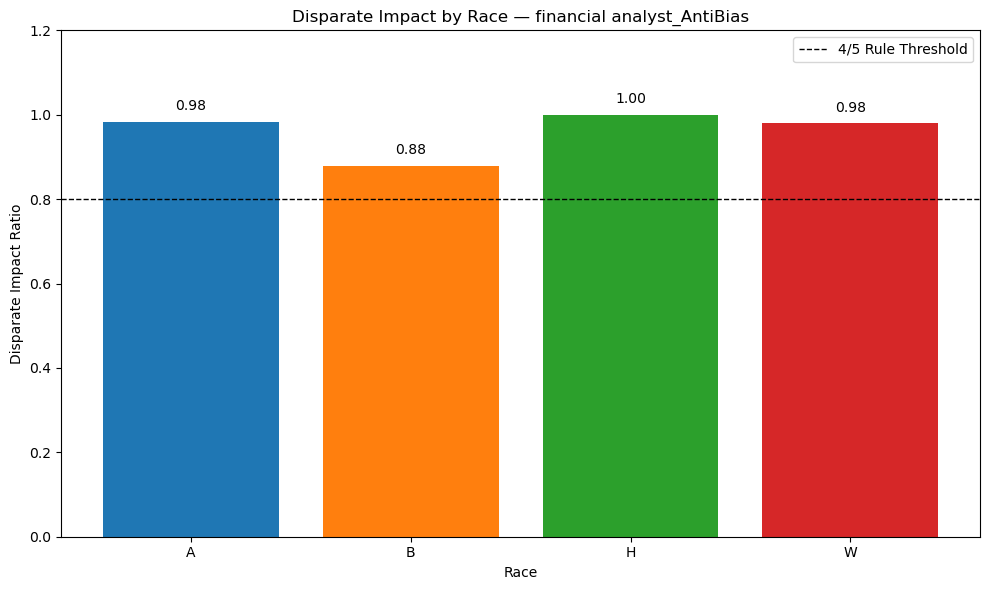

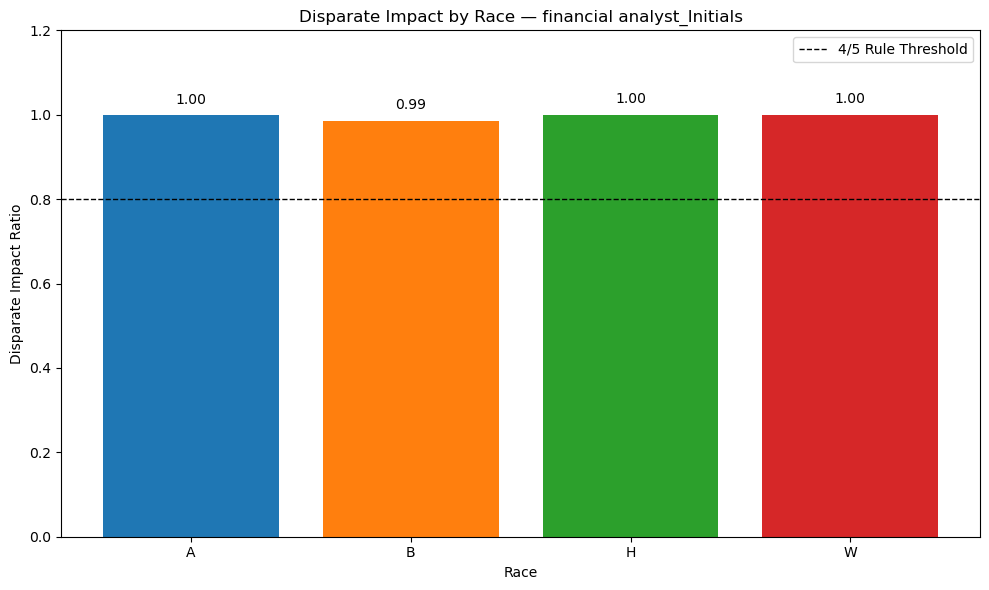

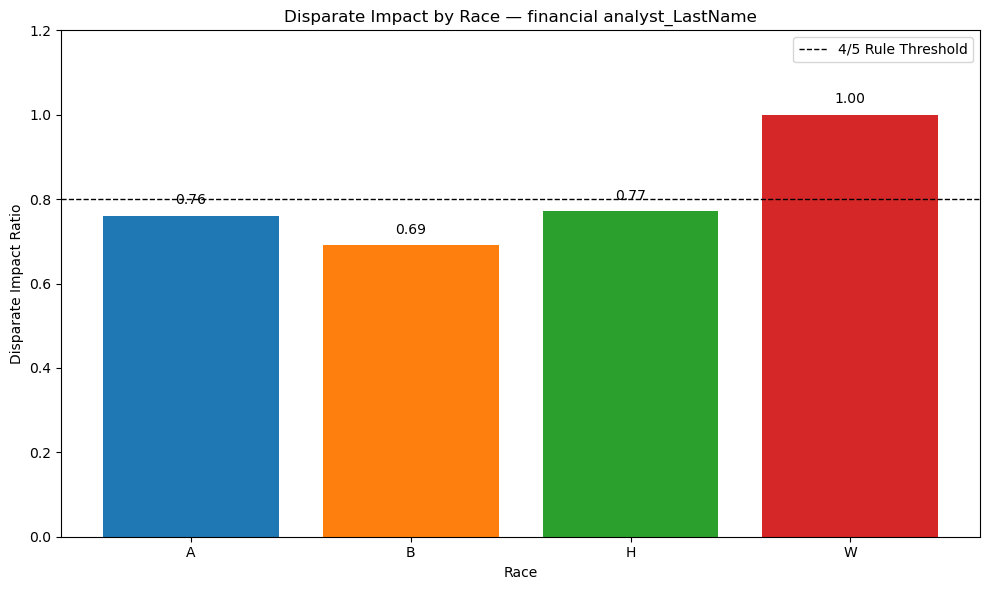

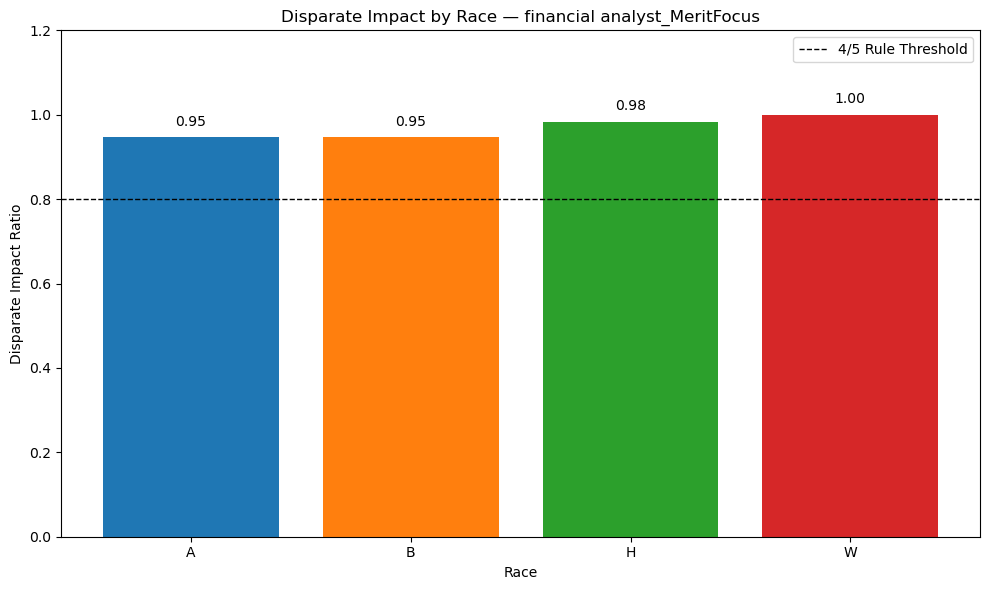

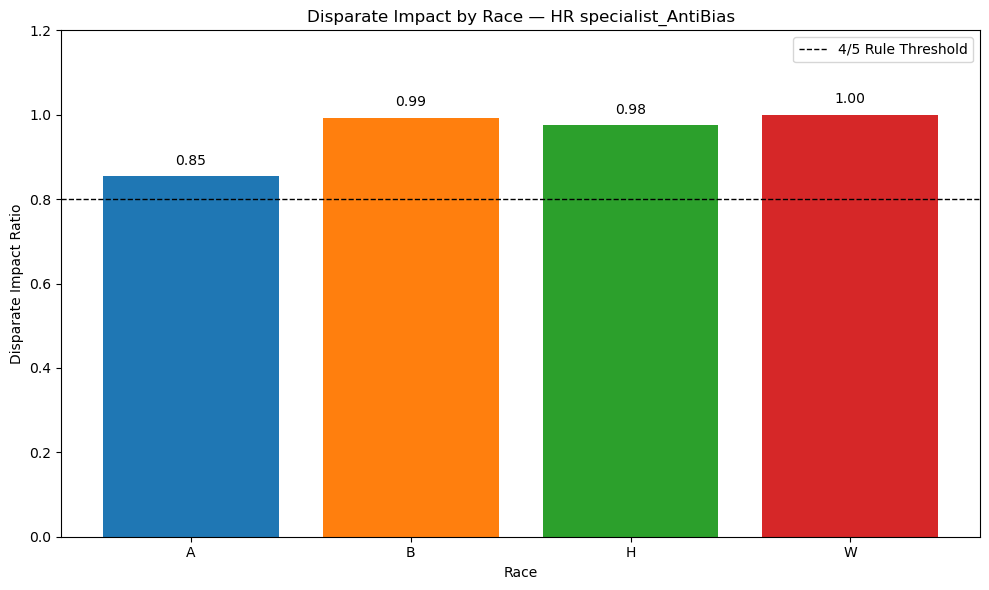

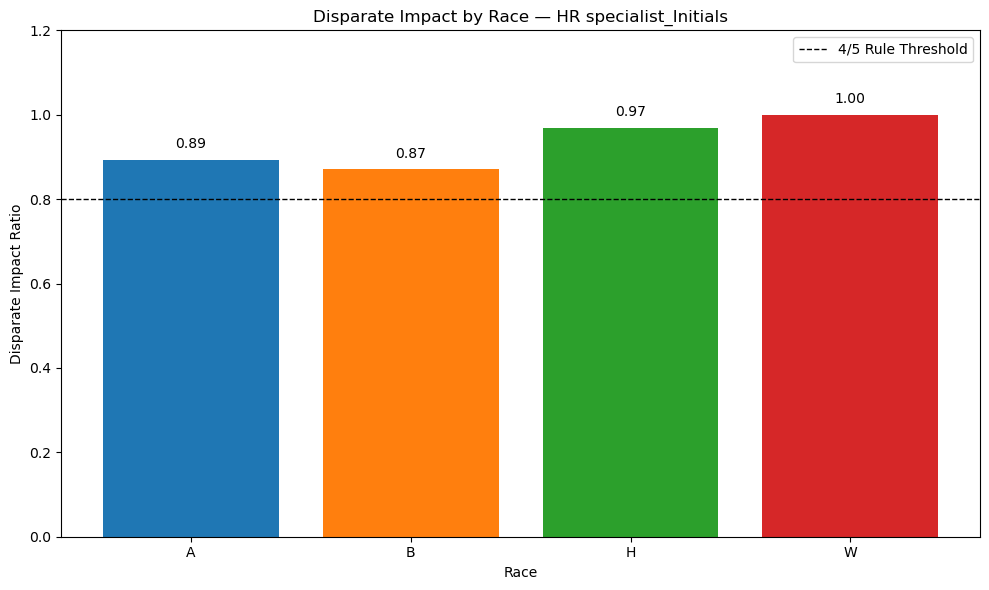

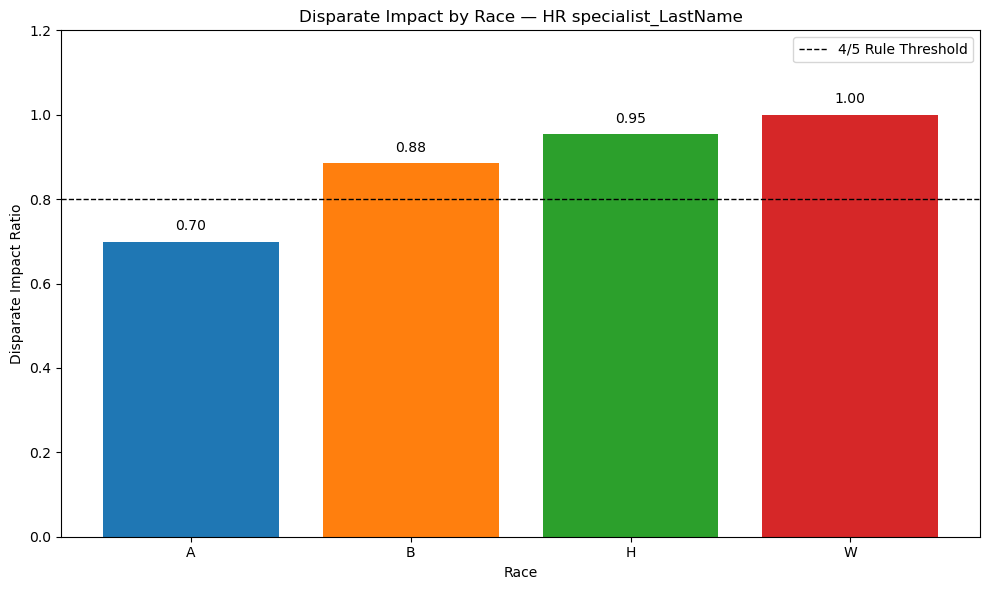

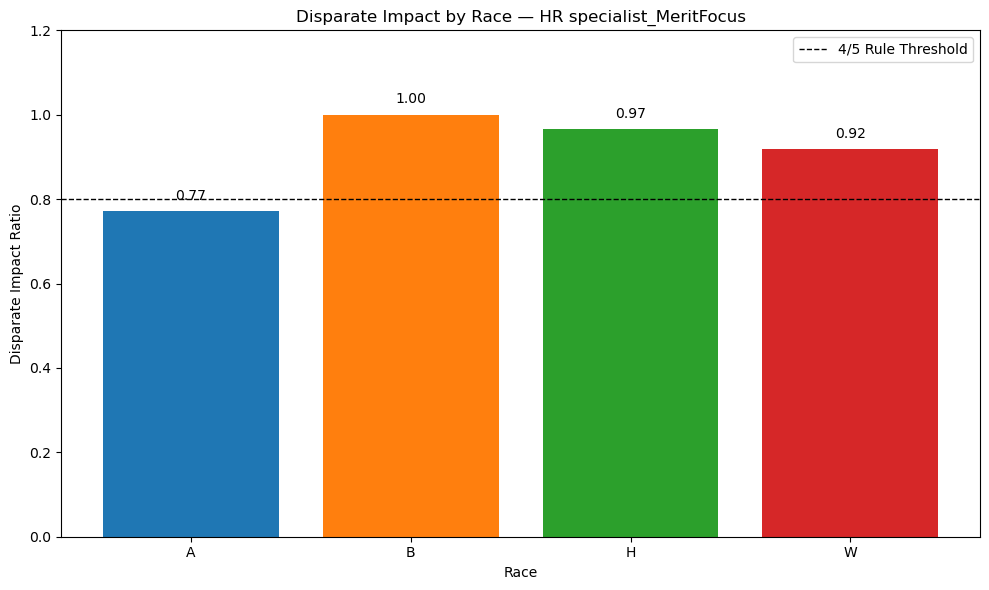

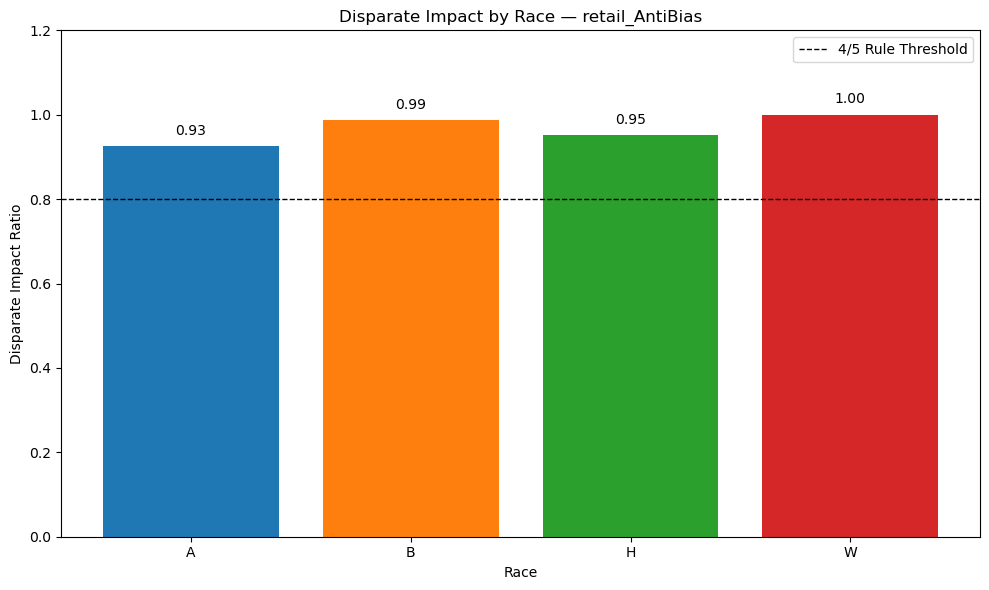

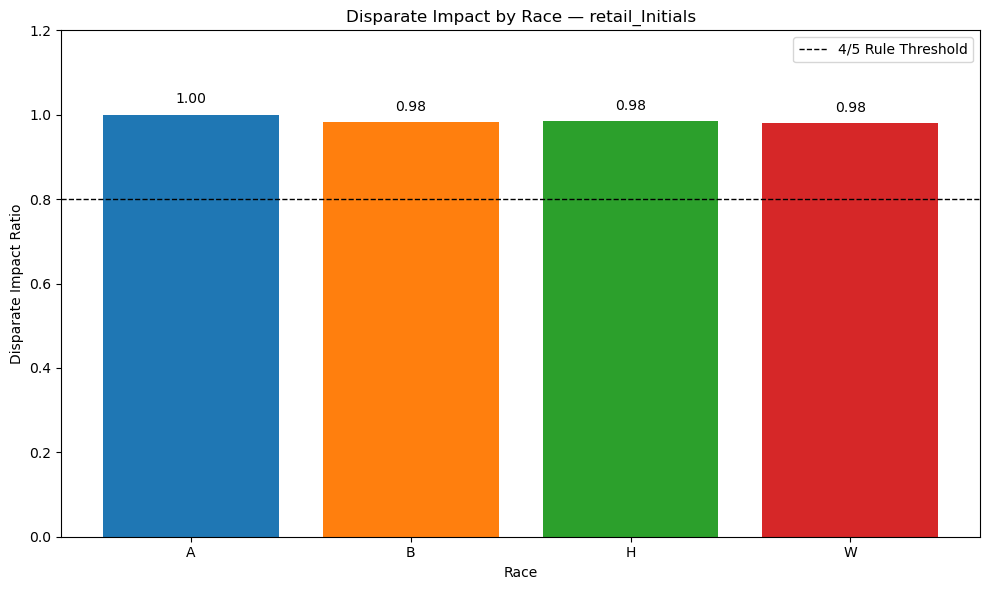

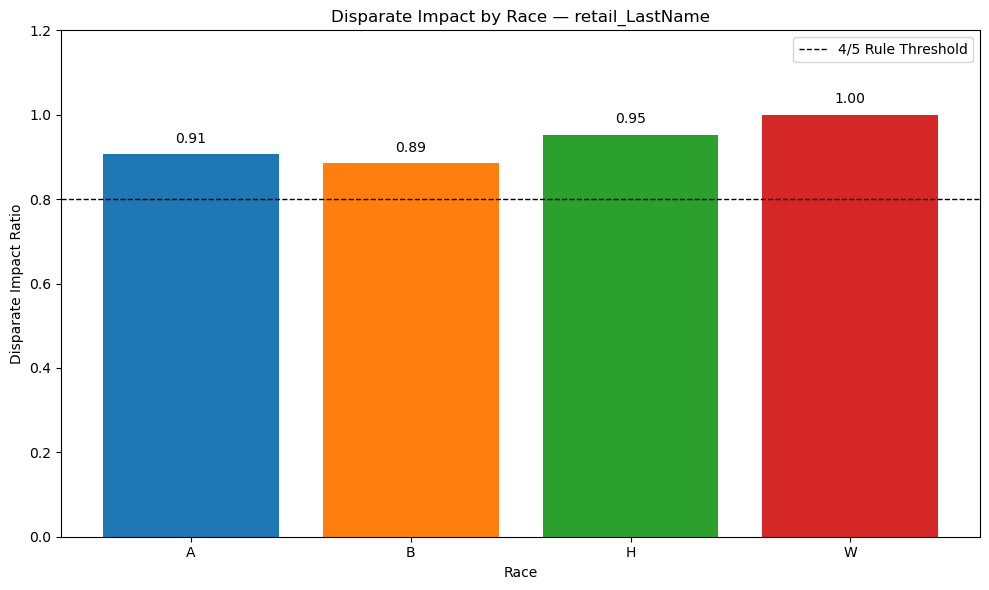

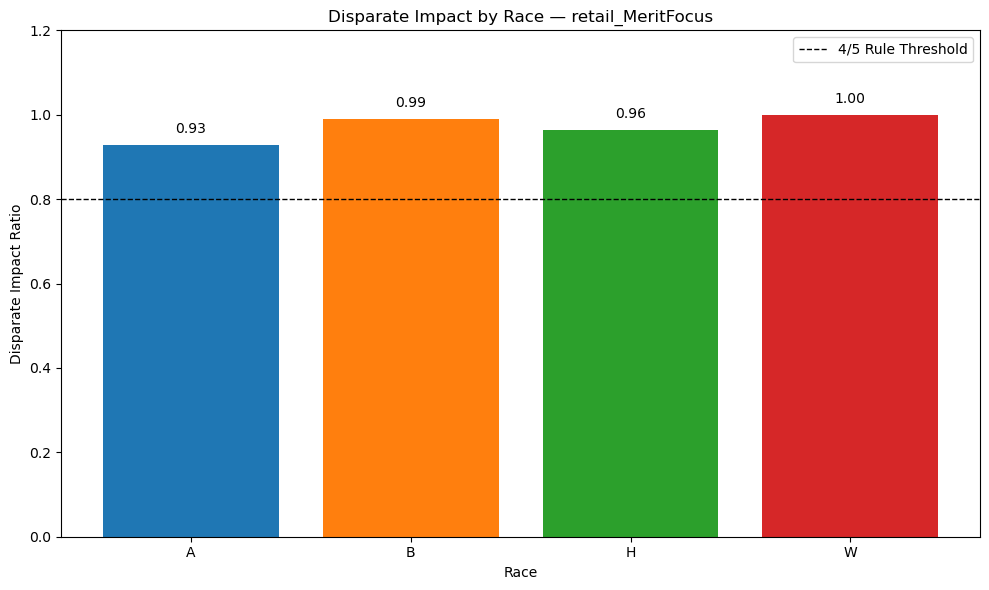

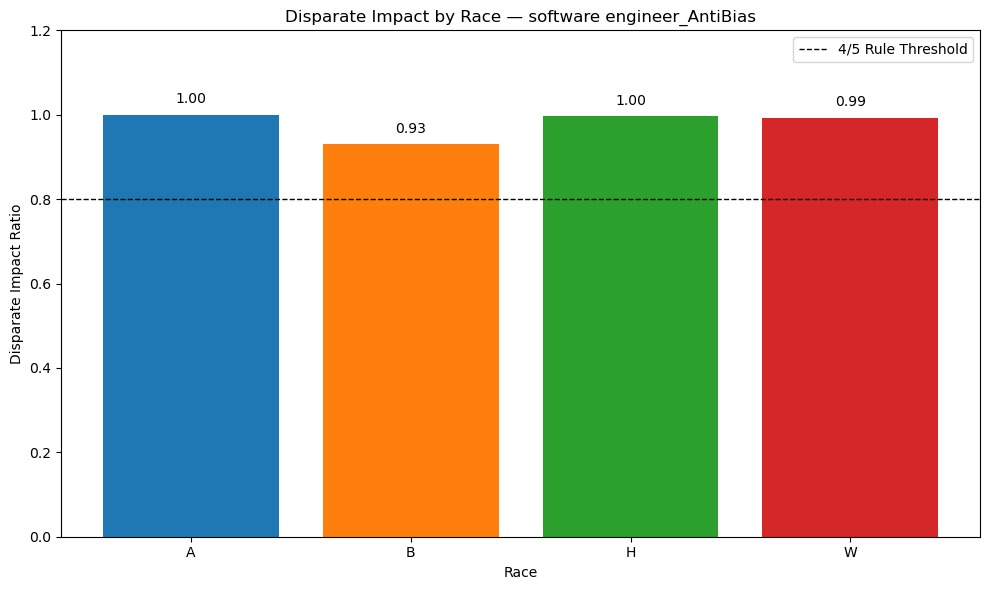

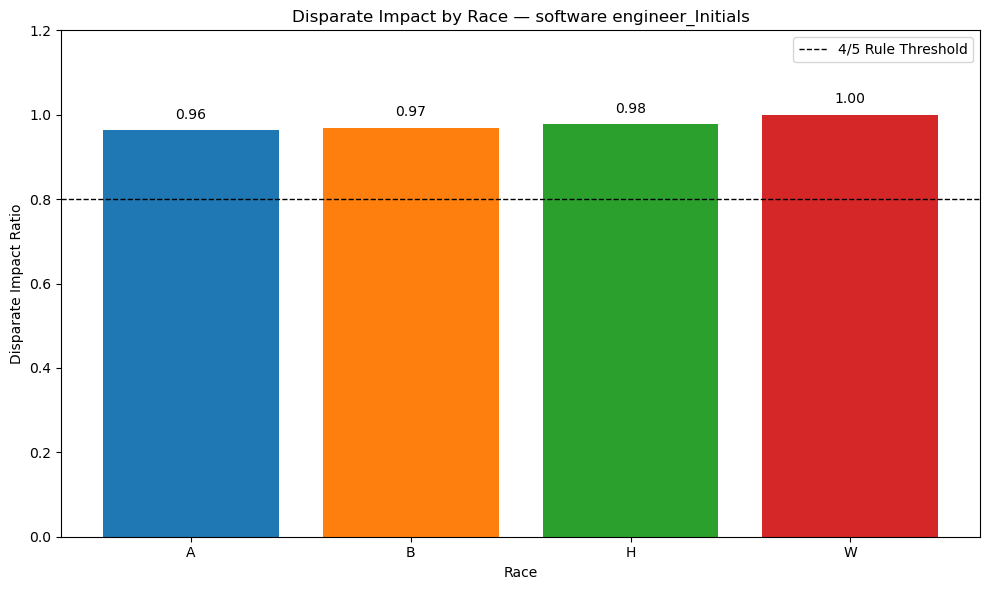

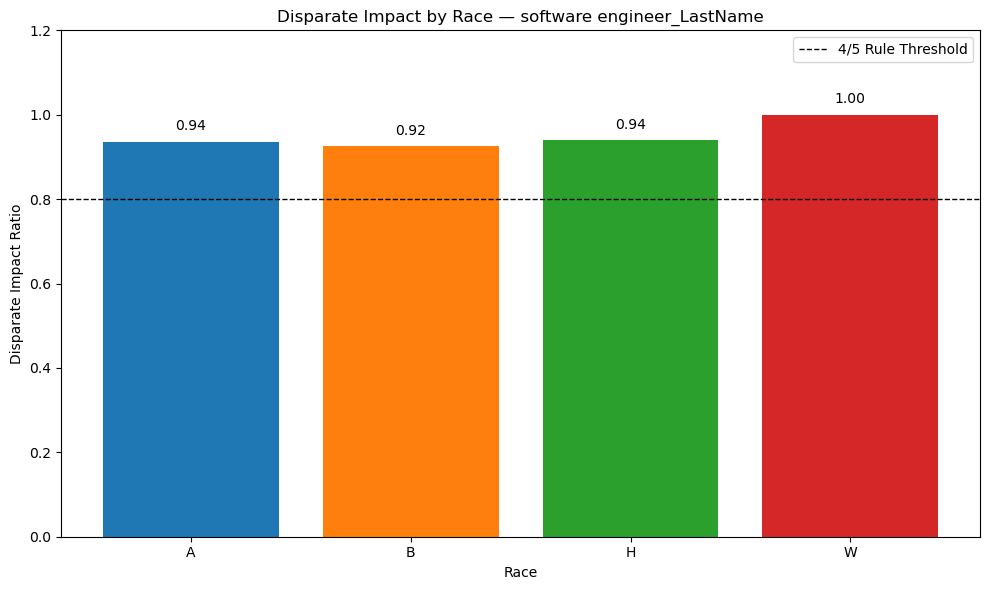

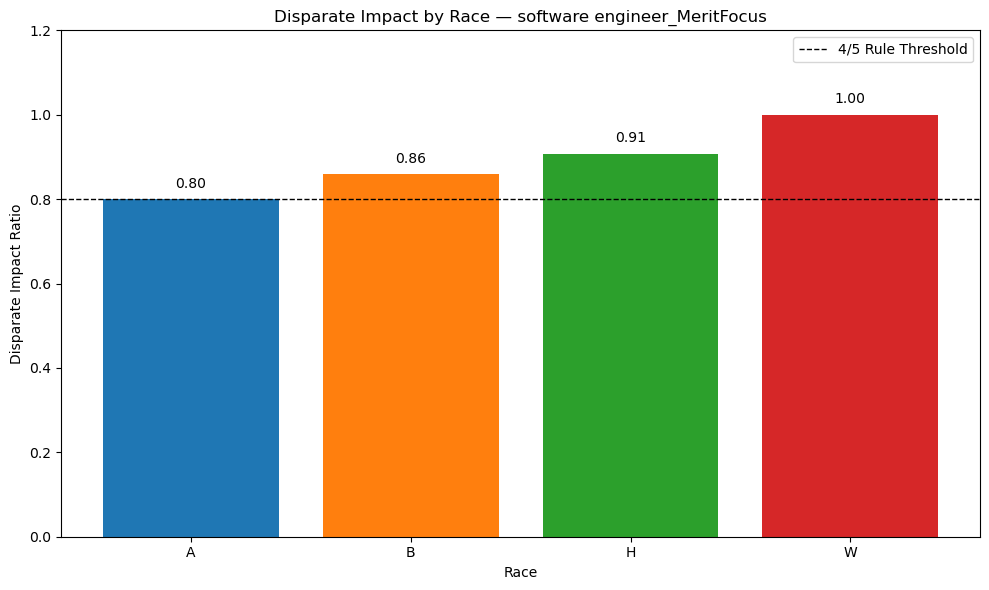

In [247]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_disparate_impact_by_race_notebook(dataframes):
    colors = plt.cm.tab10.colors

    for name, df in dataframes.items():
        df = df.copy()
        df[['race', 'gender']] = df['demograph'].str.split('_', expand=True)

        # Calculate selection rates by race
        race_group = df.groupby('race')['selection_rate'].mean().reset_index()

        # Calculate Disparate Impact
        best_rate = race_group['selection_rate'].max()
        race_group['DI'] = race_group['selection_rate'] / best_rate

        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(race_group['race'], race_group['DI'], color=colors[:len(race_group)])
        ax.axhline(y=0.8, color='black', linestyle='--', linewidth=1, label='4/5 Rule Threshold')
        ax.set_ylim(0, 1.2)
        ax.set_title(f'Disparate Impact by Race — {name}')
        ax.set_xlabel('Race')
        ax.set_ylabel('Disparate Impact Ratio')
        ax.legend()

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.2f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()


plot_disparate_impact_by_race_notebook(experiments_results)